In [2]:
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
import torch
import languagemodel
import embedding
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODELS = [
    languagemodel.BERT(DEVICE, 'bert-base-cased', 32),
    languagemodel.BERT(DEVICE, 'distilbert-base-cased', 32),
    languagemodel.XLNet(DEVICE, 'xlnet-base-cased', 32),
    languagemodel.XLM(DEVICE, 'xlm-mlm-en-2048', 32),
    languagemodel.GPT2(DEVICE, 'gpt2', 32),
#     embedding.Word2Vec(DEVICE, 'w2v', '../gensim_w2v.txt')
]

Loading word embeddings from ../gensim_w2v.txt ...


KeyboardInterrupt: 

In [5]:
def get_pmis(model, sentences, n_sentences='all', verbose=False):
    '''get estimates get scores for n (default all) sentences'''

    savez_dict = dict()

    if n_sentences == 'all':
        n_sentences = len(sentences)

    for i, sentence in enumerate(tqdm(sentences[:n_sentences])):
        pmi_dict = dict()
        # get a pmi matrix and a pseudo-logprob for the sentence
        pmi_matrix, pseudo_loglik = model.ptb_tokenlist_to_pmi_matrix(
            sentence, add_special_tokens=True, verbose=verbose,
            pad_left=None, pad_right=None)
        if verbose:
            tqdm.write(f"pmi for sentence {i}\n{sentence}")
            tqdm.write(f"pseudo_loglik: {pseudo_loglik}")
            tqdm.write(f"{pmi_matrix}")
        pmi_dict['sentence'] = sentence
        pmi_dict['pmi_matrix'] = pmi_matrix
        pmi_dict['pseudo_loglik'] = pseudo_loglik

        savez_dict[str(i)] = pmi_dict
    return savez_dict

In [6]:
sentences=[
    "Each of the four earthly elements has its natural place .",
    "By soul he simply meant the form of a living being .",
    "Increasingly , women are contributing more to household income than men .",
    "Multiplying all observations by a constant does not alter significance .",
    "The bigger one is farther away . It just looks smaller .",
    "The bigger ones are farther away . It just looks smaller .",
    "The bigger one was farther away . It just looks smaller .",
    "The bigger ones slid farther away . It just looks smaller .",
    "To process this document will take a long time .",
    "This document will take a long time to process ."
]
sentences = [line.strip().split(' ')
                     for line in sentences]
pmis_dicts = []
for _, model in enumerate(MODELS):
    pmis_dicts.append(get_pmis(model, sentences))

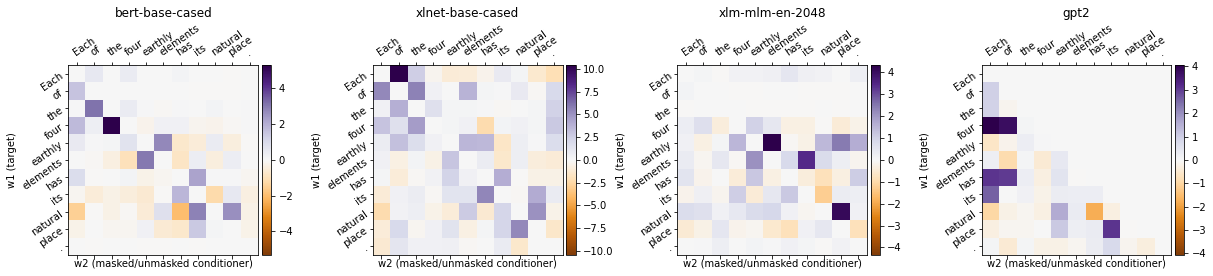

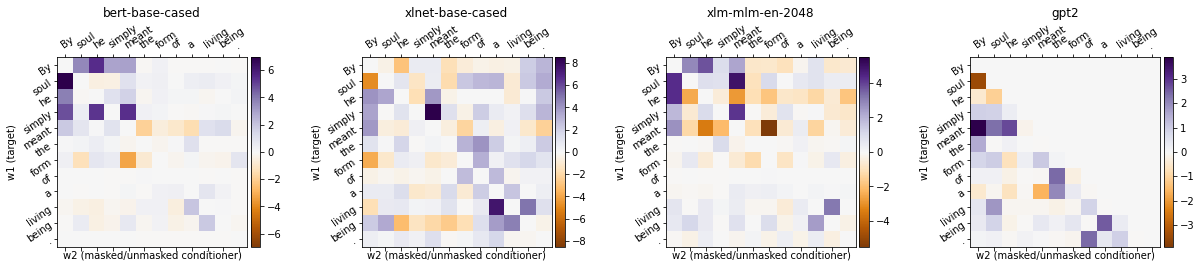

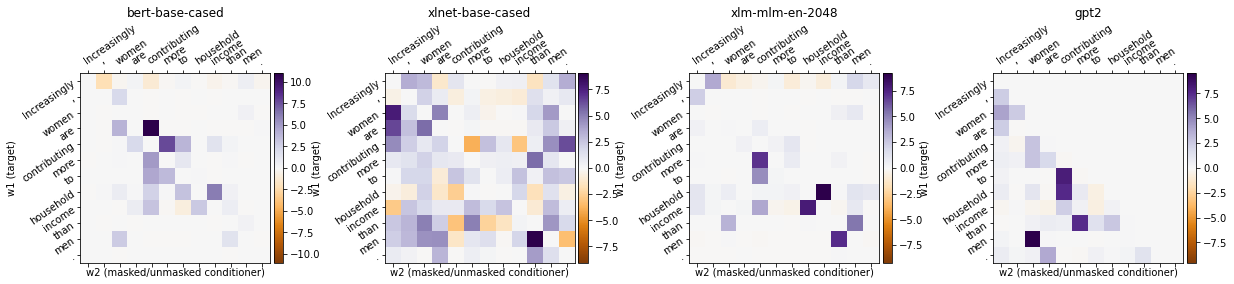

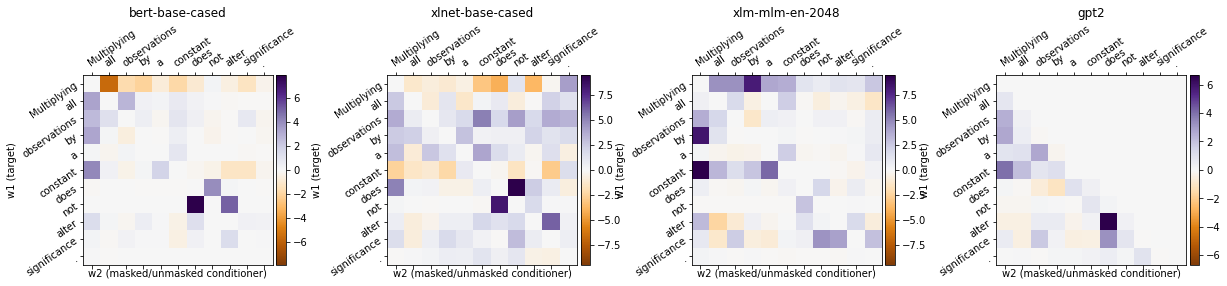

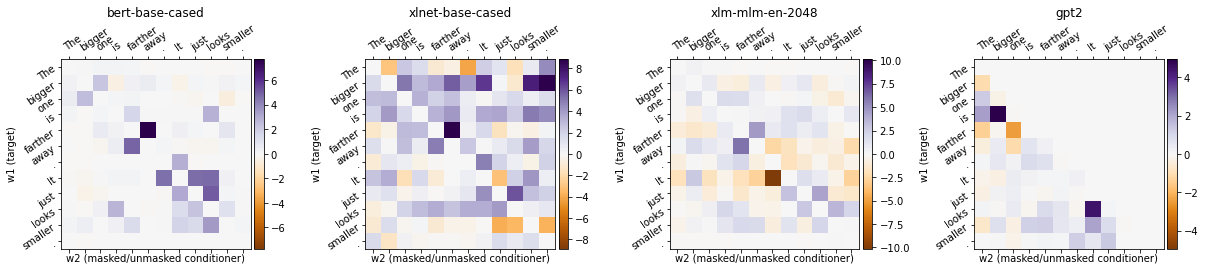

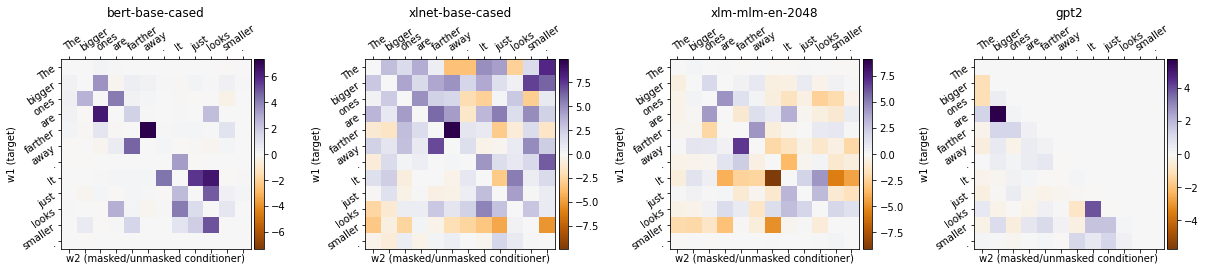

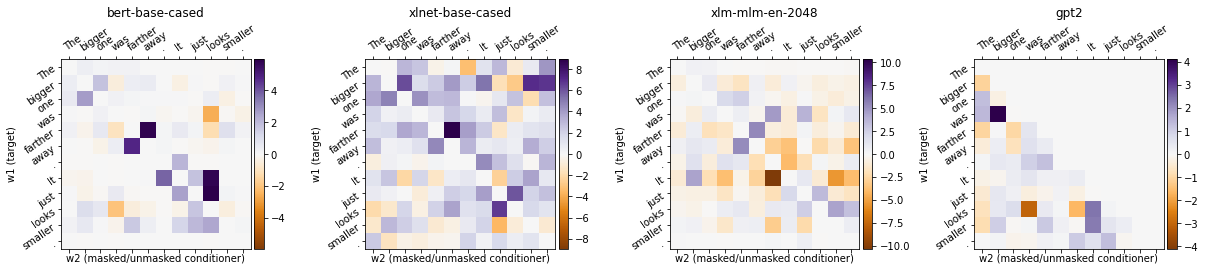

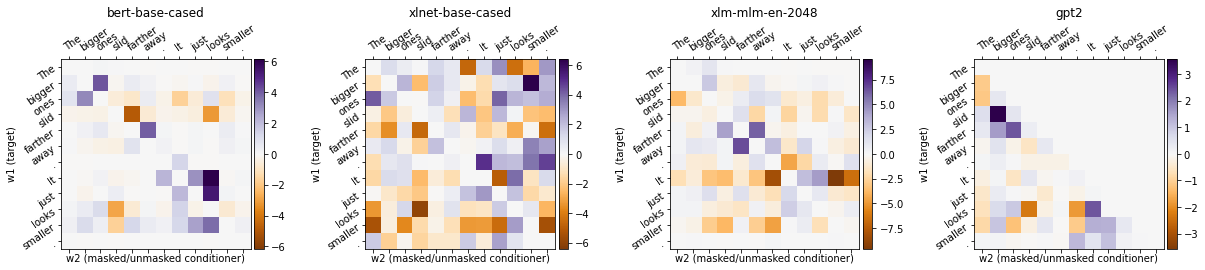

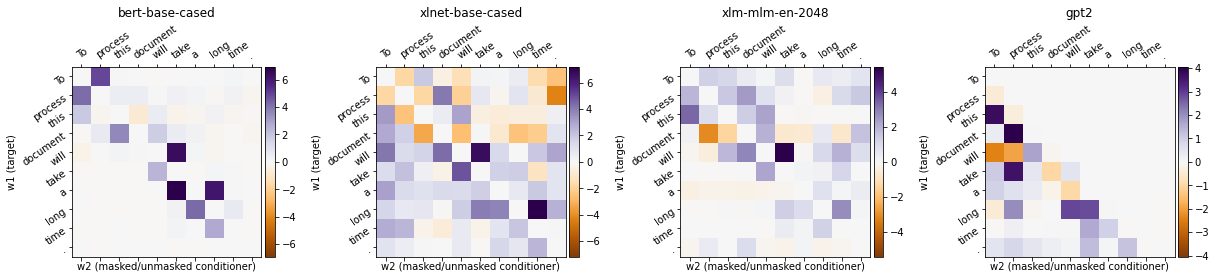

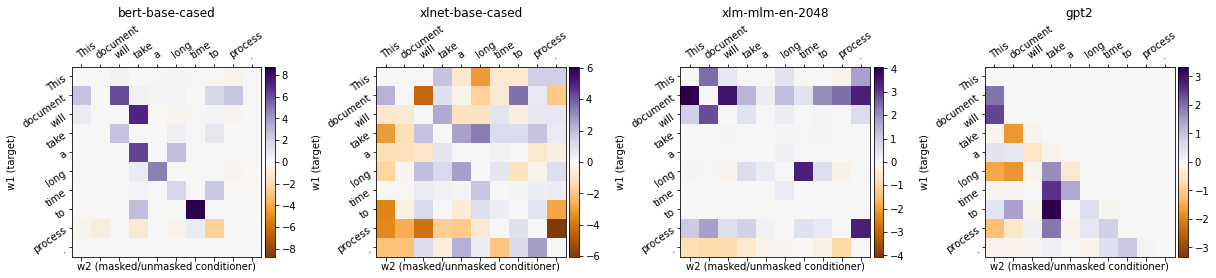

In [8]:
def show_pmi_plot(sent, mat, fig=None, ax=None, title=None):
    lim=max(abs(np.min(mat)),abs(np.max(mat)))
    if ax is None:
        fig, ax = plt.subplots()
    cax = ax.matshow(
        mat, cmap='PuOr',
        norm=colors.TwoSlopeNorm(vcenter=0, vmin=-lim, vmax=lim))
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cax, cax=cax1)
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.tick_params(axis="x", labelrotation=40)
    ax.set_xlabel('w2 (masked/unmasked conditioner)')
    ax.set_ylabel('w1 (target)')
    ax.yaxis.set_label_position("left")
    if title is not None:
        ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=35, ha="left", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=35, ha="right", rotation_mode="anchor")

for s,_ in enumerate(sentences):
    # row of plots for sentence s
    figh = 5
    fig, plots = plt.subplots(
        nrows=1, sharex=True, ncols=len(MODELS),
        figsize=(len(MODELS)*figh,figh))
    for m,_ in enumerate(MODELS):
        # plot for sentence s for model m
        pmis_dict=pmis_dicts[m]
        pmis = pmis_dict[str(s)]
        sent, mat = pmis['sentence'], pmis['pmi_matrix']
        show_pmi_plot(
            sent, mat, fig=fig, ax=plots[m], 
            title=MODELS[m].model_spec)
    plt.subplots_adjust(wspace=.5)
    plt.show()

In [88]:
with np.printoptions(precision=1, suppress=True):
    for d in pmis_dicts[0].values():
        print(*d['sentence'])
        print(d['pmi_matrix'])

Each of the four earthly elements has its natural place .
[[ 0.   0.5  0.   0.5  0.   0.   0.1  0.   0.  -0.   0. ]
 [ 1.5  0.   0.   0.   0.   0.   0.  -0.  -0.  -0.   0. ]
 [ 0.1  3.2  0.   0.5  0.1 -0.1  0.1  0.   0.1  0.   0.1]
 [ 1.8  0.3  5.3  0.  -0.2  0.2  0.2 -0.2 -0.2 -0.   0.1]
 [ 0.5  0.1  0.1  0.7  0.   2.8 -0.7 -0.5  0.4 -0.4 -0. ]
 [ 0.  -0.1 -0.4 -1.   3.1  0.  -0.8  0.4 -0.4  0.3  0. ]
 [ 0.9 -0.   0.   0.1 -0.2 -0.1  0.   2.3  0.1  0.1 -0.1]
 [-0.1 -0.5 -0.3 -0.4 -0.6 -0.   1.9  0.  -1.2  0.5 -0.3]
 [-1.5 -0.  -0.3 -0.1 -0.5  0.8 -2.   2.9  0.   2.6 -0.3]
 [-0.2  0.  -0.1 -0.1  0.2 -0.6 -0.7  1.4  0.1  0.  -0.2]
 [ 0.  -0.   0.   0.  -0.  -0.   0.  -0.   0.   0.   0. ]]
By soul he simply meant the form of a living being .
[[ 0.   3.6  5.5  2.9  3.  -0.1  0.3 -0.1 -0.  -0.   0.  -0. ]
 [ 7.   0.  -0.5 -0.4  1.   0.2  0.4  0.   0.4  0.5  0.3  0.1]
 [ 3.8 -0.1  0.   1.   1.6 -0.1  0.3  0.1  0.1 -0.1  0.   0.2]
 [ 4.8  0.5  5.3  0.   5.4  0.3  0.2 -0.  -0.1  0.1  0.1  0. 